In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc

In [2]:
from sys import platform

if platform == "darwin":
    rc("font", family="AppleGothic")
if platform == "linux" or platform == "linux2":
    plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["axes.unicode_minus"] = False

In [3]:
import matplotlib

[f.name for f in matplotlib.font_manager.fontManager.ttflist if "Nanum" in f.name]

['NanumSquareRound',
 'NanumGothicCoding',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumSquareRound',
 'NanumMyeongjo Eco',
 'NanumMyeongjo Eco',
 'NanumBarunGothic',
 'NanumSquare_ac',
 'NanumGothic',
 'NanumMyeongjo',
 'NanumBarunpen',
 'NanumMyeongjo Eco',
 'NanumGothicCoding',
 'NanumMyeongjo YetHangul',
 'NanumSquareRound',
 'NanumBarunGothic',
 'NanumGothic Eco',
 'NanumGothic',
 'NanumMyeongjo Eco',
 'NanumSquareRound',
 'Nanum Pen Script',
 'NanumBarunGothic YetHangul',
 'NanumGothic Eco',
 'NanumGothic',
 'NanumGothic Eco',
 'NanumMyeongjo',
 'NanumGothic',
 'NanumSquare_ac',
 'NanumSquare_ac',
 'NanumBarunGothic',
 'NanumBarunpen',
 'NanumSquare',
 'NanumBarunGothic',
 'Nanum Brush Script',
 'NanumGothic Eco',
 'NanumSquare_ac',
 'NanumSquare',
 'NanumSquare']

In [4]:
ori_df = pd.read_csv("data/JEJU_MCT_DATA_v2.csv", encoding="cp949")

In [5]:
df = ori_df.copy()

In [ ]:
print(len(df))

67864


In [7]:
# Remove rows where 'ADDR_fixed' is empty or consists of only whitespace
df = df[~df["ADDR"].str.strip().eq("")]

In [8]:
# Function to split the address into the desired 3 categories based on the rules you provided
def split_address(address):
    # Split the address by spaces
    parts = address.split()

    if len(parts) >= 2:
        # Main region (제주시 or 서귀포시)
        main_region = parts[1]

        # Check if the second part contains '동', '읍', or '면'
        if "동" in parts[2]:
            return main_region, parts[2], np.nan  # No third category for '동'
        elif "읍" in parts[2] or "면" in parts[2]:
            if len(parts) >= 4:
                return (
                    main_region,
                    parts[2],
                    parts[3],
                )  # Include '리' as the third category
            else:
                return main_region, parts[2], np.nan  # No '리' part present
    return np.nan, np.nan, np.nan  # Default return for unexpected address formats


# Apply the function to the fixed address column
df["ADDR_1"], df["ADDR_2"], df["ADDR_3"] = zip(*df["ADDR"].apply(split_address))

In [9]:
df[["ADDR_1", "ADDR_2", "ADDR_3"]].head(10)

,ADDR_1,ADDR_2,ADDR_3
0,제주시,용담이동,NaN
1,제주시,애월읍,애월리
2,서귀포시,색달동,NaN
3,제주시,한림읍,협재리
4,제주시,노형동,NaN
5,제주시,일도일동,NaN
6,제주시,아라일동,NaN
7,제주시,연동,NaN
8,서귀포시,토평동,NaN
9,제주시,아라일동,NaN


In [10]:
# Modify the classify_area function to account for specific island cases
def classify_area_with_islands(row):
    if pd.isna(row["ADDR_3"]):
        # If it's within the city
        if "제주시" in row["ADDR_1"]:
            return "제주 시내"
        elif "서귀포시" in row["ADDR_1"]:
            return "서귀포 시내"
    else:
        # Handle specific island cases
        if "우도면" in row["ADDR_2"]:
            return "우도"
        elif "추자면" in row["ADDR_2"]:
            return "추자도"
        elif "가파리" in row["ADDR_3"] and "대정읍" in row["ADDR_2"]:
            return "가파도"
        else:
            # Remove '읍' or '면' from other second category areas
            return row["ADDR_2"].replace("읍", "").replace("면", "").strip()


# Apply the updated function to create a new column with the adjusted region types
df["Region_Type"] = df.apply(classify_area_with_islands, axis=1)

In [11]:
# Group by 'Region_Type' and take one sample for each group
df_sampled_by_region = (
    df[["ADDR_1", "ADDR_2", "ADDR_3", "Region_Type"]]
    .groupby("Region_Type")
    .apply(lambda x: x.sample(1))
    .reset_index(drop=True)
)

df_sampled_by_region

,ADDR_1,ADDR_2,ADDR_3,Region_Type
0,서귀포시,대정읍,가파리,가파도
1,제주시,구좌읍,월정리,구좌
2,서귀포시,남원읍,남원리,남원
3,서귀포시,대정읍,무릉리,대정
4,서귀포시,서귀동,NaN,서귀포 시내
5,서귀포시,성산읍,고성리,성산
6,서귀포시,안덕면,사계리,안덕
7,제주시,애월읍,하귀2리,애월
8,제주시,우도면,연평리,우도
9,제주시,용담삼동,NaN,제주 시내


In [12]:
# Display the unique values of MCT_TYPE
unique_region_types = df["Region_Type"].unique()

# Show the unique MCT_TYPE values
unique_region_types

array(['제주 시내', '애월', '서귀포 시내', '한림', '대정', '한경', '조천', '성산', '표선', '구좌',
       '안덕', '남원', '우도', '가파도', '추자도'], dtype=object)

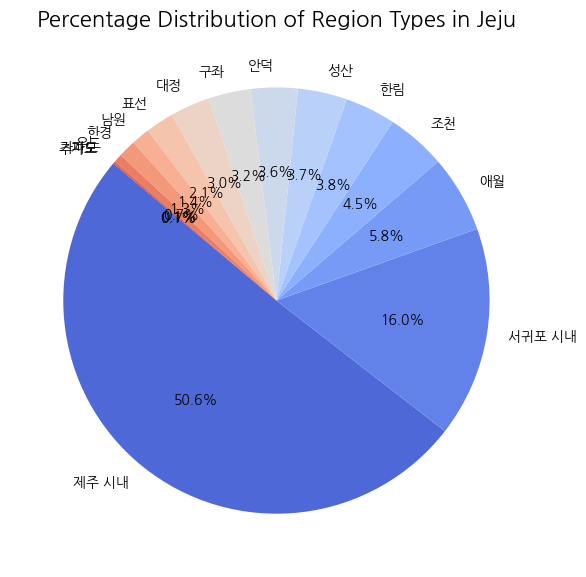

In [13]:
region_type_counts_with_islands = df["Region_Type"].value_counts(normalize=True) * 100
region_data = region_type_counts_with_islands.reset_index()
region_data.columns = ["Region", "Percentage"]

plt.figure(figsize=(6, 6))
plt.pie(
    region_data["Percentage"],
    labels=region_data["Region"],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("coolwarm", len(region_data)),
)

# Add a title
plt.title("Percentage Distribution of Region Types in Jeju", fontsize=16)

# Display the pie chart
plt.tight_layout()
plt.show()

In [14]:
# Display the unique values of MCT_TYPE
unique_mct_types = df["MCT_TYPE"].unique()

# Show the unique MCT_TYPE values
unique_mct_types

array(['가정식', '단품요리 전문', '커피', '베이커리', '일식', '치킨', '중식', '분식', '햄버거',
       '양식', '맥주/요리주점', '아이스크림/빙수', '피자', '샌드위치/토스트', '차', '꼬치구이',
       '기타세계요리', '구내식당/푸드코트', '떡/한과', '도시락', '도너츠', '주스', '동남아/인도음식',
       '패밀리 레스토랑', '기사식당', '야식', '스테이크', '포장마차', '부페', '민속주점'],
      dtype=object)

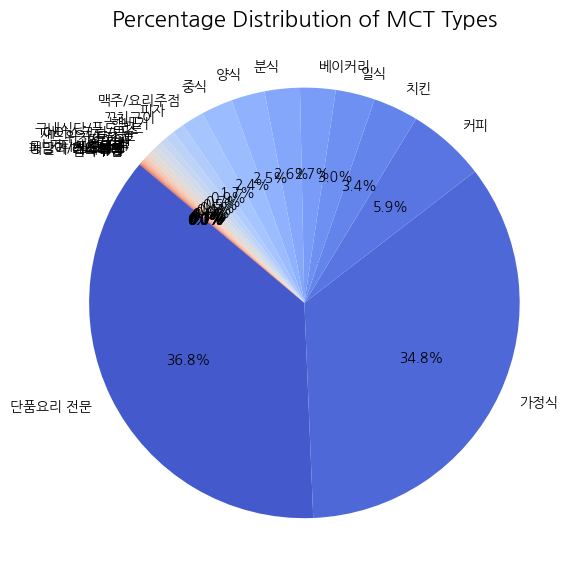

In [15]:
# Calculate the percentage of each MCT_TYPE
mct_type_percentages = df["MCT_TYPE"].value_counts(normalize=True) * 100


plt.figure(figsize=(6, 6))
plt.pie(
    mct_type_percentages,
    labels=mct_type_percentages.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("coolwarm", len(mct_type_percentages)),
)

# Add a title
plt.title("Percentage Distribution of MCT Types", fontsize=16)

# Display the pie chart
plt.tight_layout()
plt.show()

In [16]:
from datetime import datetime

# Current reference date (September 2024)
reference_date = datetime(2024, 9, 1)

# Convert 'OP_YMD' to datetime format
df["OP_YMD"] = pd.to_datetime(df["OP_YMD"], format="%Y%m%d", errors="coerce")

# Calculate the number of years since opening
df["Years_Old"] = df["OP_YMD"].apply(
    lambda x: (reference_date - x).days / 365 if pd.notnull(x) else None
)

# Remove entries with missing or invalid 'OP_YMD'
df = df.dropna(subset=["Years_Old"])

# Calculate the years for each quantile (0-20%, 20-40%, etc.)
quantiles = df["Years_Old"].quantile([0.2, 0.4, 0.6, 0.8])

# Convert quantiles to a DataFrame for display
quantile_years = pd.DataFrame(
    {"Quantile": ["20%", "40%", "60%", "80%"], "Years_Old": quantiles.values}
)

quantile_years

,Quantile,Years_Old
0,20%,2.598356
1,40%,4.265753
2,60%,6.435616
3,80%,10.035616


In [17]:
def extract_numeric(group_value):
    return int(group_value.split("_")[0]) if isinstance(group_value, str) else None


# Apply the function to the relevant columns to create new numerical columns
df["UE_CNT_GRP_NUM"] = df["UE_CNT_GRP"].apply(extract_numeric)
df["UE_AMT_GRP_NUM"] = df["UE_AMT_GRP"].apply(extract_numeric)
df["UE_AMT_PER_TRSN_GRP_NUM"] = df["UE_AMT_PER_TRSN_GRP"].apply(extract_numeric)

# Recommend new column names
recommended_column_names = {
    "UE_CNT_GRP_NUM": "Usage_Count_Rank",
    "UE_AMT_GRP_NUM": "Usage_Amount_Rank",
    "UE_AMT_PER_TRSN_GRP_NUM": "Avg_Transaction_Amount_Rank",
}

# Display the newly created columns with recommended names
df[["UE_CNT_GRP_NUM", "UE_AMT_GRP_NUM", "UE_AMT_PER_TRSN_GRP_NUM"]].head()

,UE_CNT_GRP_NUM,UE_AMT_GRP_NUM,UE_AMT_PER_TRSN_GRP_NUM
0,5,4,3
1,3,2,2
2,3,3,4
3,3,3,4
4,5,3,2


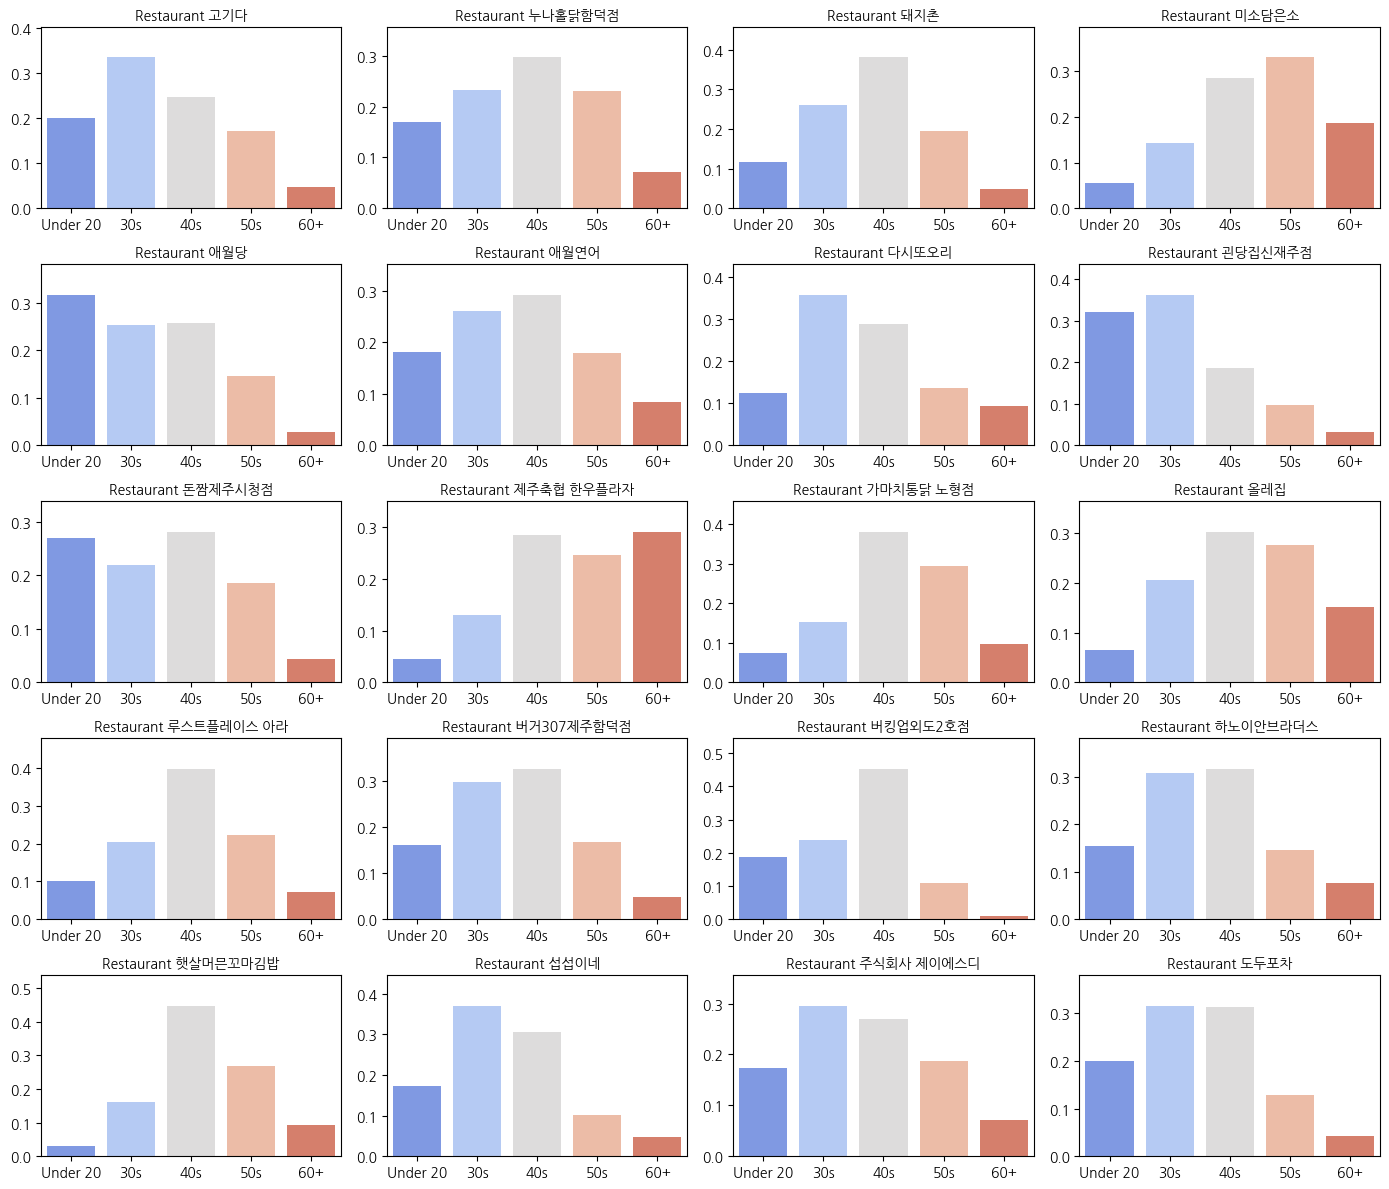

In [18]:
# Select 10 random restaurants from the dataset
random_sample = df.sample(20)

# Set up the figure for subplots
plt.figure(figsize=(14, 12))

# Iterate through each randomly selected restaurant and plot its age distribution
i = 0
for idx, row in random_sample.iterrows():
    # Create a subplot for each restaurant
    plt.subplot(5, 4, i + 1)

    # Get the age distribution for this specific restaurant
    age_distribution = [
        row["RC_M12_AGE_UND_20_CUS_CNT_RAT"],
        row["RC_M12_AGE_30_CUS_CNT_RAT"],
        row["RC_M12_AGE_40_CUS_CNT_RAT"],
        row["RC_M12_AGE_50_CUS_CNT_RAT"],
        row["RC_M12_AGE_OVR_60_CUS_CNT_RAT"],
    ]

    # Plot the age distribution for this restaurant
    sns.barplot(
        x=["Under 20", "30s", "40s", "50s", "60+"],
        y=age_distribution,
        palette="coolwarm",
    )

    # Set plot title
    plt.title(f'Restaurant {row["MCT_NM"][:10]}', fontsize=10)
    plt.ylim(0, max(age_distribution) * 1.2)  # Adjust y-axis to fit data

    # print(idx, age_distribution, f'Restaurant {row["MCT_NM"][:10]}')
    i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

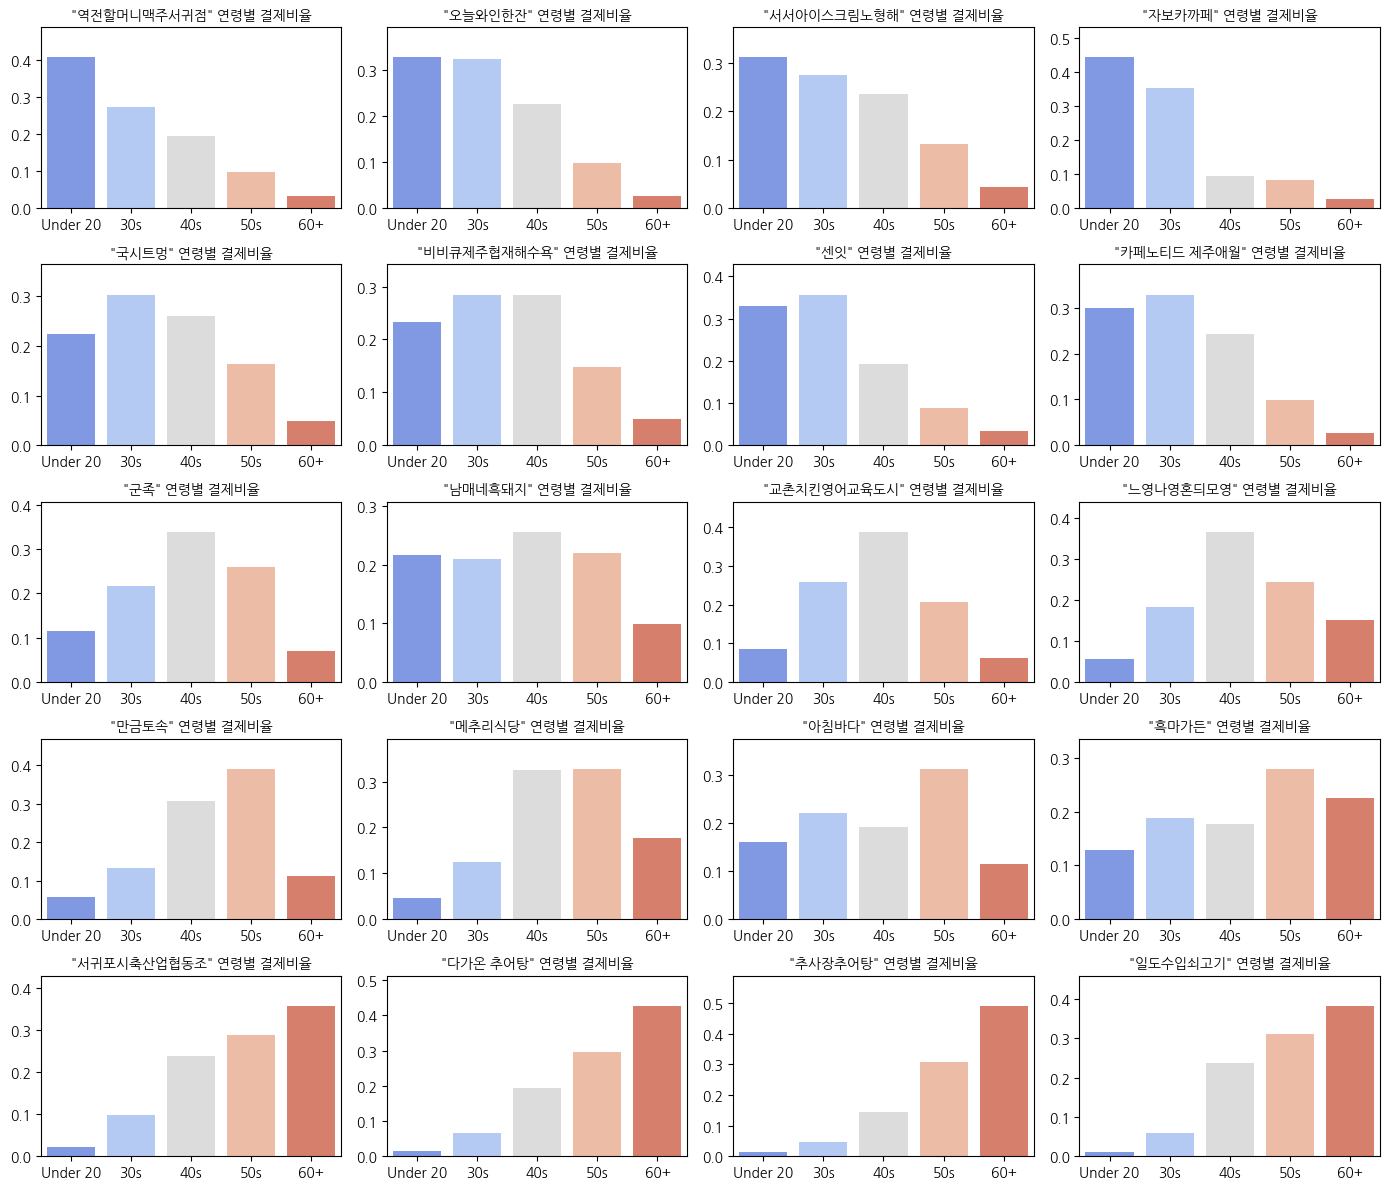

In [19]:
# Define the age columns
age_columns = [
    "RC_M12_AGE_UND_20_CUS_CNT_RAT",
    "RC_M12_AGE_30_CUS_CNT_RAT",
    "RC_M12_AGE_40_CUS_CNT_RAT",
    "RC_M12_AGE_50_CUS_CNT_RAT",
    "RC_M12_AGE_OVR_60_CUS_CNT_RAT",
]

# Add a column for the dominant age group for each restaurant
df["Dominant_Age_Group"] = df[age_columns].idxmax(axis=1)

# Map the dominant age group to more readable labels
age_group_labels = {
    "RC_M12_AGE_UND_20_CUS_CNT_RAT": "Under 20",
    "RC_M12_AGE_30_CUS_CNT_RAT": "30s",
    "RC_M12_AGE_40_CUS_CNT_RAT": "40s",
    "RC_M12_AGE_50_CUS_CNT_RAT": "50s",
    "RC_M12_AGE_OVR_60_CUS_CNT_RAT": "60+",
}
df["Dominant_Age_Group"] = df["Dominant_Age_Group"].map(age_group_labels)

# Now sample 4 restaurants from each dominant age group
sampled_restaurants = (
    df.groupby("Dominant_Age_Group").apply(lambda x: x.sample(4)).reset_index(drop=True)
)

# Sort the sampled restaurants based on the defined order of age groups
age_group_order = ["Under 20", "30s", "40s", "50s", "60+"]
sampled_restaurants["Dominant_Age_Group"] = pd.Categorical(
    sampled_restaurants["Dominant_Age_Group"], categories=age_group_order, ordered=True
)
sampled_restaurants = sampled_restaurants.sort_values("Dominant_Age_Group")

# Set up the figure for subplots
plt.figure(figsize=(14, 12))

# Iterate through each sampled restaurant and plot its age distribution
for i, (idx, row) in enumerate(sampled_restaurants.iterrows()):
    # Create a subplot for each restaurant
    plt.subplot(5, 4, i + 1)

    # Get the age distribution for this specific restaurant
    age_distribution = [
        row["RC_M12_AGE_UND_20_CUS_CNT_RAT"],
        row["RC_M12_AGE_30_CUS_CNT_RAT"],
        row["RC_M12_AGE_40_CUS_CNT_RAT"],
        row["RC_M12_AGE_50_CUS_CNT_RAT"],
        row["RC_M12_AGE_OVR_60_CUS_CNT_RAT"],
    ]

    # Plot the age distribution for this restaurant
    sns.barplot(
        x=["Under 20", "30s", "40s", "50s", "60+"],
        y=age_distribution,
        palette="coolwarm",
    )

    # Set plot title
    plt.title(f'"{row["MCT_NM"][:10]}" 연령별 결제비율', fontsize=10)
    plt.ylim(0, max(age_distribution) * 1.2)  # Adjust y-axis to fit data

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

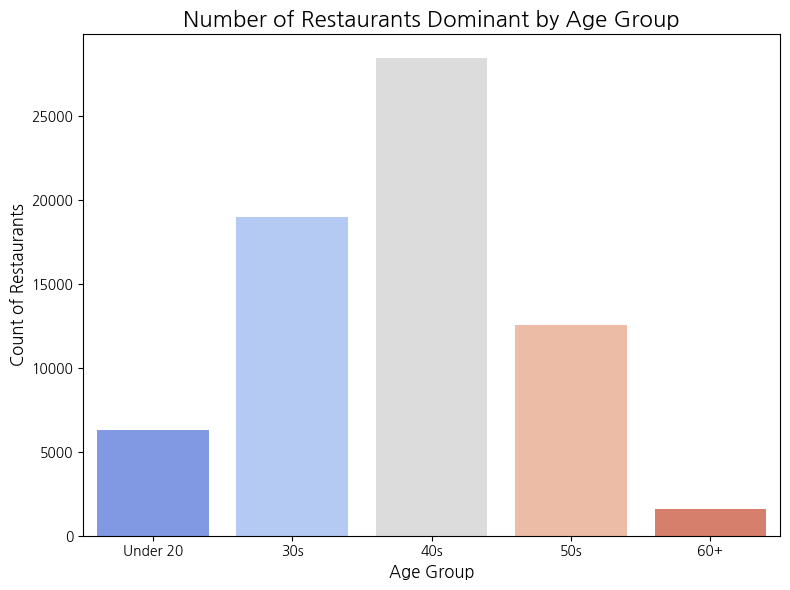

In [ ]:
# Count the number of restaurants for each dominant age group
age_group_counts = df["Dominant_Age_Group"].value_counts()

# Ensure the count index is aligned with the predefined age group order
age_group_order = ["Under 20", "30s", "40s", "50s", "60+"]
age_group_counts = age_group_counts.reindex(
    age_group_order, fill_value=0
)  # Fill missing values with 0

# Plot the dominant age group counts in the correct order
plt.figure(figsize=(8, 6))

# Create a bar plot for the dominant age group counts in the specified order
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="coolwarm")

# Add labels and title, keeping them consistent
plt.title("Number of Restaurants Dominant by Age Group", fontsize=16)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count of Restaurants", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
columns_to_drop = [
    "Under_20_Dominant",
    "30s_Dominant",
    "40s_Dominant",
    "50s_Dominant",
    "60+_Dominant",
]
df = df.drop(columns=columns_to_drop, errors="ignore")

In [22]:
threshold = 0.8


# Function to create boolean columns based on threshold logic
def create_dominant_columns(row, threshold=threshold):
    # Extract the age distribution for the restaurant
    age_distribution = row[
        [
            "RC_M12_AGE_UND_20_CUS_CNT_RAT",
            "RC_M12_AGE_30_CUS_CNT_RAT",
            "RC_M12_AGE_40_CUS_CNT_RAT",
            "RC_M12_AGE_50_CUS_CNT_RAT",
            "RC_M12_AGE_OVR_60_CUS_CNT_RAT",
        ]
    ].values

    # Find the maximum value (most popular age group)
    max_value = max(age_distribution)

    # Create boolean columns based on whether the age group meets the threshold
    return {
        "Under_20_Dominant": age_distribution[0] >= threshold * max_value,
        "30s_Dominant": age_distribution[1] >= threshold * max_value,
        "40s_Dominant": age_distribution[2] >= threshold * max_value,
        "50s_Dominant": age_distribution[3] >= threshold * max_value,
        "60+_Dominant": age_distribution[4] >= threshold * max_value,
    }


# Apply the function to each row and expand into new boolean columns
dominant_columns = df.apply(create_dominant_columns, axis=1, result_type="expand")

# Combine the original dataframe with the new boolean columns
df = pd.concat([df, dominant_columns], axis=1)

# Display the new boolean columns
df[
    [
        "MCT_NM",
        "Under_20_Dominant",
        "30s_Dominant",
        "40s_Dominant",
        "50s_Dominant",
        "60+_Dominant",
    ]
].head()

,MCT_NM,Under_20_Dominant,30s_Dominant,40s_Dominant,50s_Dominant,60+_Dominant
0,통큰돼지,False,False,False,True,False
1,해변,True,True,False,True,False
2,한그릇,False,True,True,False,False
3,협재해녀의집,True,True,False,False,False
4,까망꼬숑,True,False,False,False,False


           Age Group  Count
0  Under_20_Dominant  11974
1       30s_Dominant  31926
2       40s_Dominant  43561
3       50s_Dominant  23081
4       60+_Dominant   3878


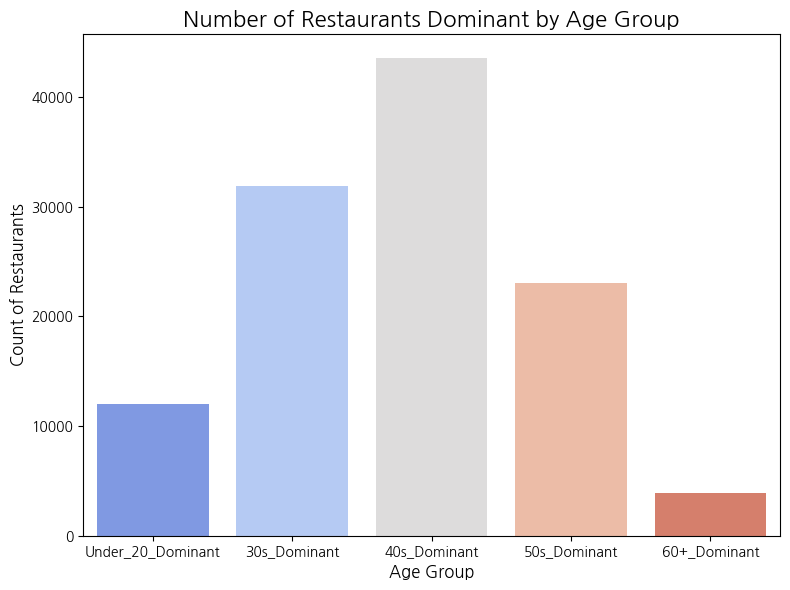

In [23]:
# Count how many restaurants are dominant for each age group
dominant_counts = {
    "Under_20_Dominant": df["Under_20_Dominant"].sum(),
    "30s_Dominant": df["30s_Dominant"].sum(),
    "40s_Dominant": df["40s_Dominant"].sum(),
    "50s_Dominant": df["50s_Dominant"].sum(),
    "60+_Dominant": df["60+_Dominant"].sum(),
}

# Convert the dictionary into a DataFrame for easier display
dominant_counts_df = pd.DataFrame(
    list(dominant_counts.items()), columns=["Age Group", "Count"]
)

# Display the result
print(dominant_counts_df)

# Create a bar plot for the dominant counts
plt.figure(figsize=(8, 6))
sns.barplot(x="Age Group", y="Count", data=dominant_counts_df, palette="coolwarm")

# Add labels and title
plt.title("Number of Restaurants Dominant by Age Group", fontsize=16)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count of Restaurants", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
address_df = pd.read_csv("data/JEJU_ADDRESS.csv", encoding="cp949")
print(len(address_df))

67915


In [25]:
address_df = address_df.drop_duplicates(subset="ADDR", keep="first", ignore_index=True)
print(len(address_df))

8842


In [ ]:
df = df.merge(address_df, on="ADDR", how="left")
print(len(df))
print(df["LATITUDE"].isnull().sum())

67853
0


In [27]:
df.head(15)

,YM,MCT_NM,OP_YMD,MCT_TYPE,ADDR,UE_CNT_GRP,UE_AMT_GRP,UE_AMT_PER_TRSN_GRP,MON_UE_CNT_RAT,TUE_UE_CNT_RAT,...,UE_AMT_GRP_NUM,UE_AMT_PER_TRSN_GRP_NUM,Dominant_Age_Group,Under_20_Dominant,30s_Dominant,40s_Dominant,50s_Dominant,60+_Dominant,LATITUDE,LONGITUDE
0,202301,통큰돼지,2011-07-01,가정식,제주 제주시 용담이동 2682-9번지 통큰돼지,5_75~90%,4_50~75%,3_25~50%,0.161290,0.032258,...,4,3,50s,False,False,False,True,False,33.506648,126.509165
1,202301,해변,2005-04-07,단품요리 전문,제주 제주시 애월읍 애월리 410-6번지,3_25~50%,2_10~25%,2_10~25%,0.090909,0.121212,...,2,2,50s,True,True,False,True,False,33.465878,126.323536
2,202301,한그릇,2012-09-19,단품요리 전문,제주 서귀포시 색달동 2315-1번지 한그릇,3_25~50%,3_25~50%,4_50~75%,0.224719,0.112360,...,3,4,40s,False,True,True,False,False,33.257270,126.415518
3,202301,협재해녀의집,2013-06-27,가정식,제주 제주시 한림읍 협재리 1459-2번지,3_25~50%,3_25~50%,4_50~75%,0.000000,0.271739,...,3,4,Under 20,True,True,False,False,False,33.398882,126.243925
4,202301,까망꼬숑,2022-08-26,단품요리 전문,제주 제주시 노형동 3784-12번지 1층,5_75~90%,3_25~50%,2_10~25%,0.272727,0.121212,...,3,2,Under 20,True,False,False,False,False,33.482649,126.480485
5,202301,동진,2016-05-23,가정식,제주 제주시 일도일동 1146번지,2_10~25%,3_25~50%,5_75~90%,0.117647,0.176471,...,3,5,40s,True,True,True,False,False,33.513106,126.527480
6,202301,컴포즈커피 제주아라점,2020-07-02,커피,제주 제주시 아라일동 6104번지 1층,1_상위 10% 이하,5_75~90%,6_90% 초과(하위 10% 이하),0.207161,0.150895,...,5,6,40s,False,True,True,False,False,33.475992,126.544999
7,202301,(주)시더스초밥제주연동점,2022-03-15,단품요리 전문,제주 제주시 연동 355-8번지 1층,5_75~90%,5_75~90%,3_25~50%,0.133333,0.266667,...,5,3,40s,False,True,True,True,False,33.484955,126.501894
8,202301,토평골식당,2005-07-04,가정식,제주 서귀포시 토평동 1245-7번지,6_90% 초과(하위 10% 이하),5_75~90%,1_상위 10% 이하,0.181818,0.272727,...,5,1,50s,False,False,False,True,False,33.268024,126.591803
9,202301,원삼계탕아라점,2009-06-09,단품요리 전문,제주 제주시 아라일동 1813-2번지 1층,3_25~50%,3_25~50%,4_50~75%,0.175258,0.113402,...,3,4,40s,False,False,True,True,False,33.469592,126.548341


In [28]:
import math
import os
import pickle

from geopy.distance import geodesic
from scipy.spatial import cKDTree


# Load coastline points from the saved pickle file
def load_coastline_points(file_name="data/coastline_points.pkl"):
    if os.path.exists(file_name):
        print(f"Loading coastline points from {file_name}")
        with open(file_name, "rb") as f:
            coastline_points = pickle.load(f)
        return coastline_points
    else:
        raise FileNotFoundError(f"The file {file_name} does not exist.")


# Approximate threshold for filtering based on coordinate differences
def quick_filter_by_lat_lon(restaurant_location, coastline_point, threshold=0.0027):
    lat_diff = abs(restaurant_location[0] - coastline_point[0])
    lon_diff = abs(restaurant_location[1] - coastline_point[1])

    # Convert longitude threshold to account for latitude difference
    lon_adjusted_threshold = threshold * math.cos(math.radians(restaurant_location[0]))

    # Return True if both latitude and longitude differences are within the threshold
    return lat_diff <= threshold and lon_diff <= lon_adjusted_threshold


# Function to calculate distance in meters between two geographical points
def haversine_distance(point1, point2):
    return geodesic(point1, point2).meters


# Function to calculate the minimum distance between restaurant and coastline, after coordinate filtering
def calculate_min_distance(row, coastline_points, threshold=None):
    if threshold is None:
        # Define the thresholds for latitude and longitude differences
        threshold = 1000 / 111320  # 1000 meters converted to degrees of latitude

    # Restaurant location
    restaurant_location = (row["LATITUDE"], row["LONGITUDE"])

    # Filter coastline points based on latitude and longitude difference
    filtered_points = [
        point
        for point in coastline_points
        if quick_filter_by_lat_lon(restaurant_location, point, threshold)
    ]

    if not filtered_points:
        return 999999

    # Create a new KDTree for filtered points
    filtered_tree = cKDTree(filtered_points)

    # Find the closest coastline point using KDTree for fast nearest-neighbor lookup
    dist, idx = filtered_tree.query(restaurant_location)

    # Calculate the actual geodesic distance
    closest_coastline_point = filtered_points[idx]
    distance = haversine_distance(restaurant_location, closest_coastline_point)

    return distance

In [29]:
from tqdm import tqdm

# Load coastline points from the pickle file
coastline_points = load_coastline_points()

# Apply the distance calculation to the DataFrame 'df' using tqdm for progress tracking
df["DIST_COAST"] = 9999  # Initialize the new column

for idx, row in tqdm(
    df.iterrows(), total=len(df), desc="Calculating distance to coastline"
):
    df.at[idx, "DIST_COAST"] = calculate_min_distance(row, coastline_points)

Loading coastline points from data/coastline_points.pkl


Calculating distance to coastline: 100%|██████████| 67853/67853 [03:01<00:00, 374.44it/s]


In [30]:
# df_non_nan[['DIST_COAST', 'Latitude', 'Longitude']].head(5)
print(
    df.sort_values(by="DIST_COAST", ascending=True)[
        ["DIST_COAST", "LATITUDE", "LONGITUDE"]
    ].head(10)
)
# df_non_nan[['DIST_COAST', 'LATITUDE', 'LONGITUDE']].head(5)
print(df[df["DIST_COAST"] <= 50].shape[0])
# print(df_non_nan)

       DIST_COAST   LATITUDE   LONGITUDE
42187    3.254588  33.442368  126.278816
19509    3.254588  33.442368  126.278816
14028    3.254588  33.442368  126.278816
31834    3.254588  33.442368  126.278816
9673     3.254588  33.442368  126.278816
61160    6.064606  33.506339  126.464281
25827    6.064606  33.506339  126.464281
20523    6.064606  33.506339  126.464281
38381    6.064606  33.506339  126.464281
14743    6.064606  33.506339  126.464281
4028


In [31]:
df["OP_YMD"].info

<bound method Series.info of 0       2011-07-01
1       2005-04-07
2       2012-09-19
3       2013-06-27
4       2022-08-26
           ...    
67848   2023-06-30
67849   2021-05-13
67850   2002-01-12
67851   2004-01-09
67852   2020-06-02
Name: OP_YMD, Length: 67853, dtype: datetime64[ns]>

In [32]:
df["OP_YMD_INT"] = df["OP_YMD"].dt.strftime("%Y%m%d").astype(int)

In [33]:
mct_blue_matched = pd.read_csv("data/MCT_BLUE_MATCHED.csv", encoding="cp949")

# Create a set of matched MCT_NM names for faster lookup
matched_mct_names = set(mct_blue_matched["MCT_NAME"])

# Create a new column in JEJU_MCT_DATA indicating if the MCT_NM is in the matched list
df["BLUE_RIBBON"] = df["MCT_NM"].apply(
    lambda x: True if x in matched_mct_names else False
)

In [34]:
# Perform the join for parking data
parking_matched_data = pd.read_csv(
    "data/MCT_PARKING_MATCHED.csv", encoding="cp949"
)  # Contains MCT_NM, OP_YMD, PARK_NAME_ADDR
parking_matched_data["OP_YMD_INT"] = (
    pd.to_datetime(parking_matched_data["OP_YMD"]).dt.strftime("%Y%m%d").astype(int)
)
parking_matched_data = parking_matched_data.drop(columns=["OP_YMD"])

df = pd.merge(df, parking_matched_data, on=["MCT_NM", "OP_YMD_INT"], how="left")

In [35]:
# Drop the specified columns from the dataframe
columns_to_remove = ["UE_CNT_GRP", "UE_AMT_GRP", "UE_AMT_PER_TRSN_GRP"]
df = df.drop(columns=columns_to_remove, errors="ignore")

In [36]:
df.to_csv("data/JEJU_PROCESSED.csv", encoding="cp949", index=False)